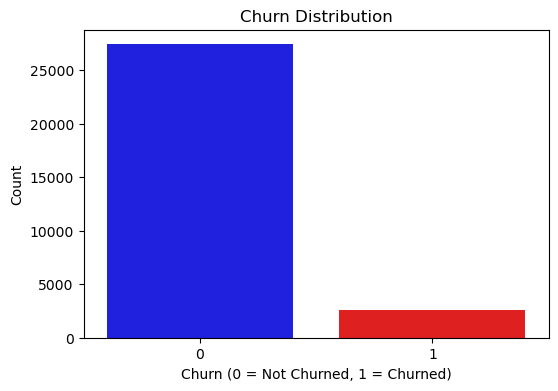

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      5492
           1       0.89      0.90      0.90      5476

    accuracy                           0.90     10968
   macro avg       0.90      0.90      0.90     10968
weighted avg       0.90      0.90      0.90     10968

ROC AUC Score: 0.8971599303482535
Random Forest Performance:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      5492
           1       0.96      0.97      0.96      5476

    accuracy                           0.96     10968
   macro avg       0.96      0.96      0.96     10968
weighted avg       0.96      0.96      0.96     10968

ROC AUC Score: 0.9648159458448626
Best Model Selected: RandomForestClassifier


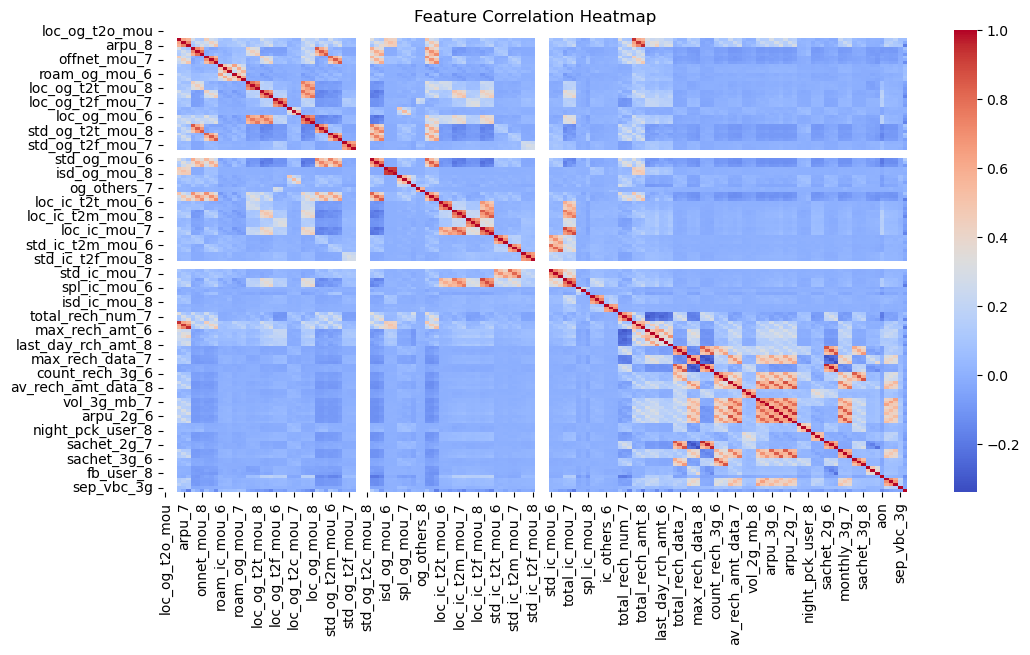

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

# Load the dataset
df = pd.read_csv("C:\\Users\\DELL\\Downloads\\telecom_churn_data_new.csv")

# Data Preprocessing
# Convert date columns to datetime format
date_cols = [col for col in df.columns if "date" in col]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Handle missing values (Fill NaN with median values)
for col in df.columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Filter high-value customers
X_threshold = df[['total_rech_amt_6', 'total_rech_amt_7']].mean(axis=1).quantile(0.70)
df = df[df[['total_rech_amt_6', 'total_rech_amt_7']].mean(axis=1) >= X_threshold]

# Tag churners
df['churn'] = ((df['total_ic_mou_9'] == 0) &
               (df['total_og_mou_9'] == 0) &
               (df['vol_2g_mb_9'] == 0) &
               (df['vol_3g_mb_9'] == 0)).astype(int)

# Drop columns for the churn phase
columns_to_drop = [col for col in df.columns if col.endswith('_9')]
df.drop(columns=columns_to_drop, inplace=True)

# Feature Selection (Dropping non-useful columns)
df.drop(columns=['mobile_number', 'circle_id'], inplace=True)

# Remove non-numeric columns before modeling
existing_date_cols = [col for col in date_cols if col in df.columns]
df.drop(columns=existing_date_cols, inplace=True, errors='ignore')
df = df.select_dtypes(include=[np.number])  # Keep only numeric columns

# Data Visualization
plt.figure(figsize=(6, 4))
sns.countplot(x=df['churn'], palette=['blue', 'red'])
plt.title('Churn Distribution')
plt.xlabel('Churn (0 = Not Churned, 1 = Churned)')
plt.ylabel('Count')
plt.show()

# Splitting Data
X = df.drop(columns=['churn'])
y = df['churn']

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training and Hyperparameter Tuning
# Logistic Regression Model
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

# Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Model Evaluation
print("Logistic Regression Performance:")
print(classification_report(y_test, y_pred_log))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_log))

print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_rf))

# Choosing the best model
best_model = rf if roc_auc_score(y_test, y_pred_rf) > roc_auc_score(y_test, y_pred_log) else log_reg
print("Best Model Selected:", best_model.__class__.__name__)

# Data Flow Visualization
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()
